In [112]:
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
library(stringr)
library(DBI)
library(dbplyr)
library(GGally)
options(repr.matrix.max.rows = 6)

# Predicting the Win Rate of Tennis Players  
<img align="left" src="https://images.unsplash.com/photo-1554068865-24cecd4e34b8?ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8dGVubmlzfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60" width="1000" />  

*Source: https://unsplash.com/photos/WqI-PbYugn4*

# Introduction<img align="left" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDixQBw3HoqS_gnC9xVtHO-5NrnS1eQ91N3w&usqp=CAU" width="35" />   


### Background 

Tennis is a popular, competitive sport played around the world. In tennis, players gain points by hitting a tennis ball, across a net in the court, in such a way that their opponent is unable to hit it back without the ball bouncing twice.

The association of tennis professionals, or ATP, organizes Tennis tournaments and collects data on the players and the matches that take place.

### Our Question

Based on the career statistics of a tennis player, what will be their win rate?

### The Dataset

We are using the "Game results for Top 500 Players from 2017-2019" dataset. Each row in this dataset represents a match between two players and contains player stats (e.g. age, height, rank) and match stats (break points, serve points, double faults etc). 


*Picture source: https://www.emojipng.com/preview/458725*

# Preliminary Exploratory Data Analysis <img align="left" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDixQBw3HoqS_gnC9xVtHO-5NrnS1eQ91N3w&usqp=CAU" width="35" />   


In [113]:
## the dataset can be read from the URL link:
atp_data_frame <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")
atp_data_frame

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2883,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,2,104542,NA,⋯,54,30,12,12,5,11,15,2320,76,667
2884,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,4,105676,NA,⋯,54,44,13,14,7,10,7,3775,15,2320
2885,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,5,106298,NA,⋯,53,29,11,11,4,11,18,2235,76,667


In [114]:

# calculate player wins and mean match stats for winning matches
player_wins <- atp_data_frame %>%
    group_by(player_id = winner_id) %>%
    summarize(w_height = mean(winner_ht, na.rm =TRUE),
              w_breakpoint_saved_pct = mean(w_bpSaved/w_bpFaced, na.rm =TRUE),
              w_second_serve_win_pct = mean(w_2ndWon / w_svpt,na.rm =TRUE),
              w_first_serve_pct = mean(w_1stWon / w_1stIn,na.rm =TRUE),
              w_first_serve_win_pct = mean(w_1stWon / w_svpt, na.rm = TRUE),
              n_wins = n(),
              mean_age_w  = mean(winner_age),
              mean_rank_points_w = mean(winner_rank_points),
              w_ace_point_pct = mean(w_ace/w_svpt,na.rm = TRUE)
             ) %>%
    drop_na() %>%
    mutate(player_id = as.character(player_id))

# calculate player losses and mean match stats for losing matches
player_lose <- atp_data_frame %>%
    group_by(player_id = loser_id) %>%
    summarize(l_height = mean(loser_ht, na.rm =TRUE),
              l_breakpoint_saved_pct = mean(l_bpSaved/l_bpFaced, na.rm =TRUE),
              l_second_serve_win_pct = mean(l_2ndWon / l_svpt,na.rm =TRUE),
              l_first_serve_pct = mean(l_1stWon / l_1stIn,na.rm =TRUE),
              l_first_serve_win_pct = mean(l_1stWon / l_svpt, na.rm = TRUE),
              n_lose = n(),
              mean_age_l  = mean(loser_age),
              mean_rank_points_l = mean(loser_rank_points),
              l_ace_point_pct = mean(l_ace/l_svpt,na.rm = TRUE)
             ) %>%
    drop_na() %>%
    mutate(player_id = as.character(player_id))

# join datasets for wins and losses using unique player ids
player_join <- left_join(player_wins, player_lose, by = NULL, copy = TRUE)

# calculate career stats for all player matches
player_career <- player_join %>%
    mutate(height = (w_height + l_height)/2,
          breakpoint_saved_pct = (w_breakpoint_saved_pct+l_breakpoint_saved_pct)/2,
          second_serve_win_pct = (w_second_serve_win_pct+l_second_serve_win_pct)/2,
          first_serve_pct = (w_first_serve_pct+l_first_serve_pct)/2,
          first_serve_win_pct = (w_first_serve_win_pct + l_first_serve_win_pct)/2,
          win_rate = (n_wins/(n_lose+n_wins)*100),
          age = (mean_age_w + mean_age_l) /2,
          mean_rank_points = (mean_rank_points_w + mean_rank_points_l)/2,
          ace_point_pct = (w_ace_point_pct+l_ace_point_pct)/2) %>%
    select(player_id,height,breakpoint_saved_pct,second_serve_win_pct,first_serve_pct,first_serve_win_pct, win_rate,age,mean_rank_points,ace_point_pct) %>%
    drop_na()

nrow(player_career)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "player_id"



[1] 103

We have grouped each unique player's matches together and calculated the mean of several key stats, creating a "career average" dataframe. Additionally, we have introduced a new stat, *win_rate*, which is the percentage of matches won by that player.

For each relationship we show a correlation coefficient indicating the strength and direction.

In [115]:
# split the data set into training and testing set. The following exploratory data analysis uses only the training set
set.seed(20)
player_split <- initial_split(player_career, prop = 0.75, strata = win_rate)
player_train <- training(player_split)
player_test <- testing(player_split)

In [116]:
# exploratory data analysis table:

# the means of the predictor variables we plan to use in our analysis
exploratory_data_analysis_table <- player_train %>%
    select(-player_id) %>%
    map_df(mean, na.rm = TRUE)
exploratory_data_analysis_table


height,breakpoint_saved_pct,second_serve_win_pct,first_serve_pct,first_serve_win_pct,win_rate,age,mean_rank_points,ace_point_pct
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
186.0253,0.5947108,0.1958433,0.7193289,0.44232,45.90908,30.0706,1208.705,0.07991921


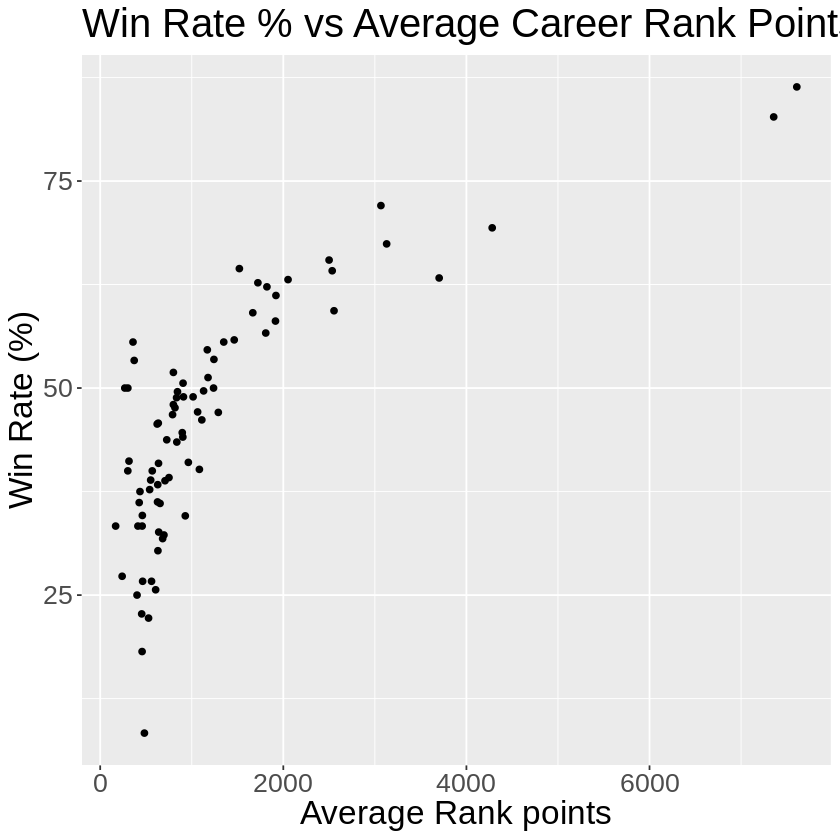

In [117]:
# exploratory data analysis plot:
exploratory_data_analysis_plot_1 <- ggplot(player_train, aes(x = mean_rank_points,y = win_rate)) + 
    geom_point() +
    xlab("Average Rank points") +
    ylab("Win Rate (%)") + 
    theme(text = element_text(size = 20)) + 
    ggtitle("Win Rate % vs Average Career Rank Points") 
exploratory_data_analysis_plot_1

1). There is a strong relationship between "average career rank points" and "win rate" is which is non-linear and positive. This sets up nicely for a KNN regression model.

2). There is a weak relationship between “average double fault rate” and the “win rate” that is negative and linear.

,win_rate
age,-0.1175338


`geom_smooth()` using formula 'y ~ x'



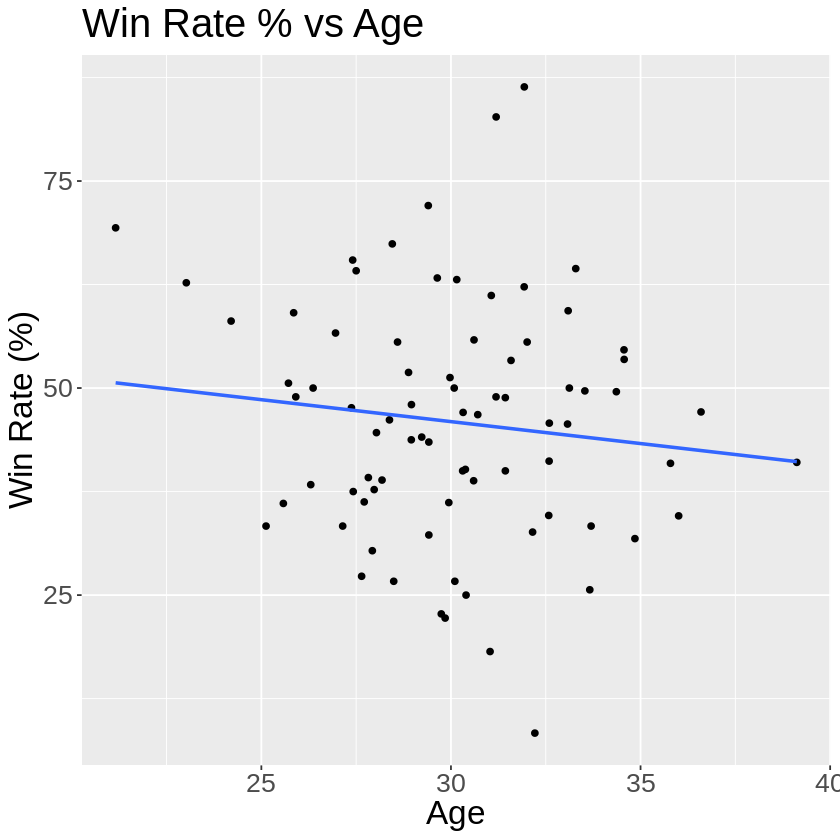

In [119]:
# exploratory data analysis plot:
exploratory_data_analysis_plot_3 <- ggplot(player_train, aes(x = age,y=win_rate)) + 
    geom_point() +
    xlab("Age") +
    ylab("Win Rate (%)") + 
    theme(text = element_text(size = 20)) + 
    geom_smooth(method = "lm", se = FALSE) +
    ggtitle("Win Rate % vs Age")
x <- select(player_train, age)
y <- select(player_train, win_rate)
c_l_2 <- cor(x, y,  method = "pearson", use = "complete.obs")
c_l_2
exploratory_data_analysis_plot_3

3). There is a weak relationship between “age” and “win rate” that is negative and linear.

,win_rate
first_serve_win_pct,0.2336128


`geom_smooth()` using formula 'y ~ x'



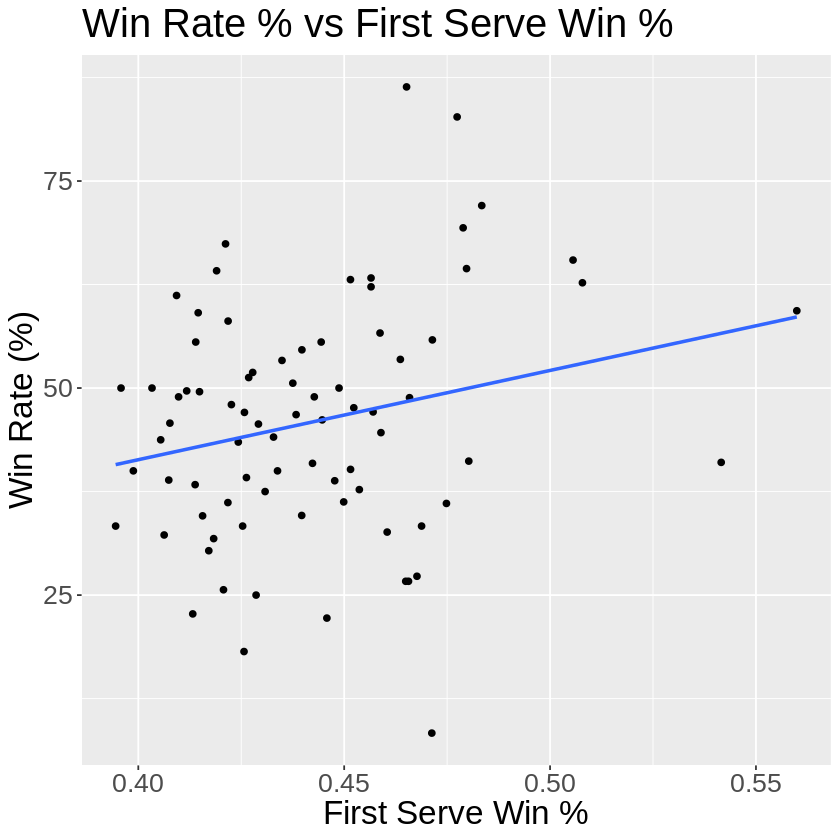

In [120]:
# exploratory data analysis plot:
exploratory_data_analysis_plot_4 <- ggplot(player_train, aes(x = first_serve_win_pct,y=win_rate)) + 
    geom_point() +
    xlab("First Serve Win %") +
    ylab("Win Rate (%)") + 
    theme(text = element_text(size = 20)) + 
    geom_smooth(method = "lm", se = FALSE) +
    ggtitle("Win Rate % vs First Serve Win %")
x <- select(player_train, first_serve_win_pct)
y <- select(player_train, win_rate)
c_l_3 <- cor(x, y,  method = "pearson", use = "complete.obs")
c_l_3
exploratory_data_analysis_plot_4

4). There is a positive linear relationship between a player’s “first serve win percentage” and “win rate”.

,win_rate
ace_point_pct,0.1655874


`geom_smooth()` using formula 'y ~ x'



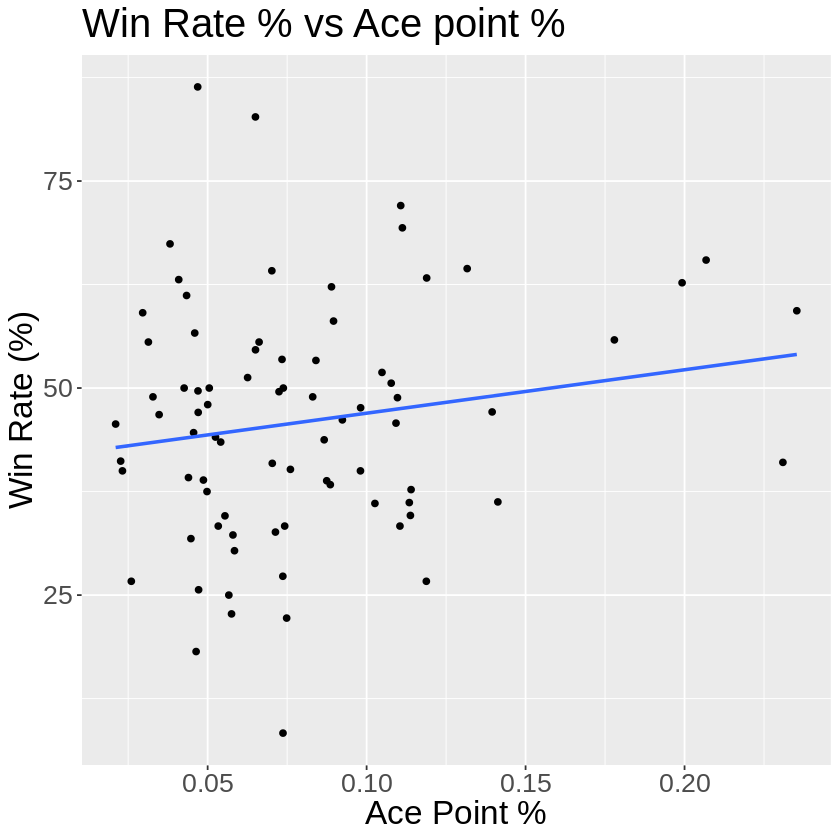

In [121]:
# exploratory data analysis plot:
exploratory_data_analysis_plot_5 <- ggplot(player_train, aes(x = ace_point_pct,y=win_rate)) + 
    geom_point() +
    xlab("Ace Point %") +
    ylab("Win Rate (%)") + 
    theme(text = element_text(size = 20)) + 
    geom_smooth(method = "lm", se = FALSE) +
    ggtitle("Win Rate % vs Ace point %")
x <- select(player_train, ace_point_pct)
y <- select(player_train, win_rate)
c_l_4 <- cor(x, y,  method = "pearson", use = "complete.obs")
c_l_4
exploratory_data_analysis_plot_5

5). There is a positive linear relationship between “ace point %” and “win rate”.

# Methods <img align="left" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDixQBw3HoqS_gnC9xVtHO-5NrnS1eQ91N3w&usqp=CAU" width="35" />  

With the following key variables, we can create a KNN regression model to predict win rate:

- Age (years)                    
- Serve Points that were Aces (%) 
- First Serves Won/Made (%)           
- Double Faults per Game (ratio)  
- Breakpoints Saved (%)           
- Rank Points                     

The KNN regression model will need to be trained, evaluated, and tuned with training and testing sets before predicting win rate on a new player. By plotting both K and RMSE (Root Mean Square Error), we will be able to visualize how each predictor affects the player's win rate. We can also analyze which combination of predictors will yield the lowest test error resulting in a more effective model.

# Expected outcomes and significance <img align="left" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDixQBw3HoqS_gnC9xVtHO-5NrnS1eQ91N3w&usqp=CAU" width="35" /> 

We expect that the estimated win rate will reflect the respective career stats of the player. If they have impressive stats, such as high breakpoint save percentage, then their win rate will be high. Conversely, lower stats mean lower win rate.  

Predicting the win rate of a given player could be useful in understanding how the player will perform in the future and making a rough estimate of a player's chances in an upcoming tournament or season. Additionally, it can be used to provide a clearer estimate of the result of a head-to-head match.  


This analysis could also prompt further questions:
 - Are there stats not included in the dataset that could improve the effectiveness of the model?
 - Do certain stats influence win rate more, and if so, is there a better weight function to use in the regression engine?


### MESSING AROUND WITH PREDICTORS

Rows: 79
Columns: 10
$ player_id            <chr> "100644", "103333", "103852", "103893", "103917"…
$ height               <dbl> 198, 208, 188, 183, 190, 188, 178, 188, 178, 190…
$ breakpoint_saved_pct <dbl> 0.5592240, 0.7024075, 0.6435922, 0.6032682, 0.63…
$ second_serve_win_pct <dbl> 0.1700660, 0.1934502, 0.2029322, 0.2086046, 0.20…
$ first_serve_pct      <dbl> 0.7351579, 0.8336761, 0.7678518, 0.7053554, 0.72…
$ first_serve_win_pct  <dbl> 0.4788888, 0.5415601, 0.4570213, 0.4156136, 0.44…
$ win_rate             <dbl> 69.346734, 41.025641, 47.115385, 34.567901, 40.9…
$ age                  <dbl> 21.15730, 39.12084, 36.59486, 36.00516, 35.78922…
$ mean_rank_points     <dbl> 4281.6435, 962.8682, 1064.2837, 929.3494, 637.01…
$ ace_point_pct        <dbl> 0.11124906, 0.23093646, 0.13948328, 0.05544316, …


[1] "player_id"            "height"               "breakpoint_saved_pct"
 [4] "second_serve_win_pct" "first_serve_pct"      "first_serve_win_pct" 
 [7] "win_rate"             "age"                  "mean_rank_points"    
[10] "ace_point_pct"

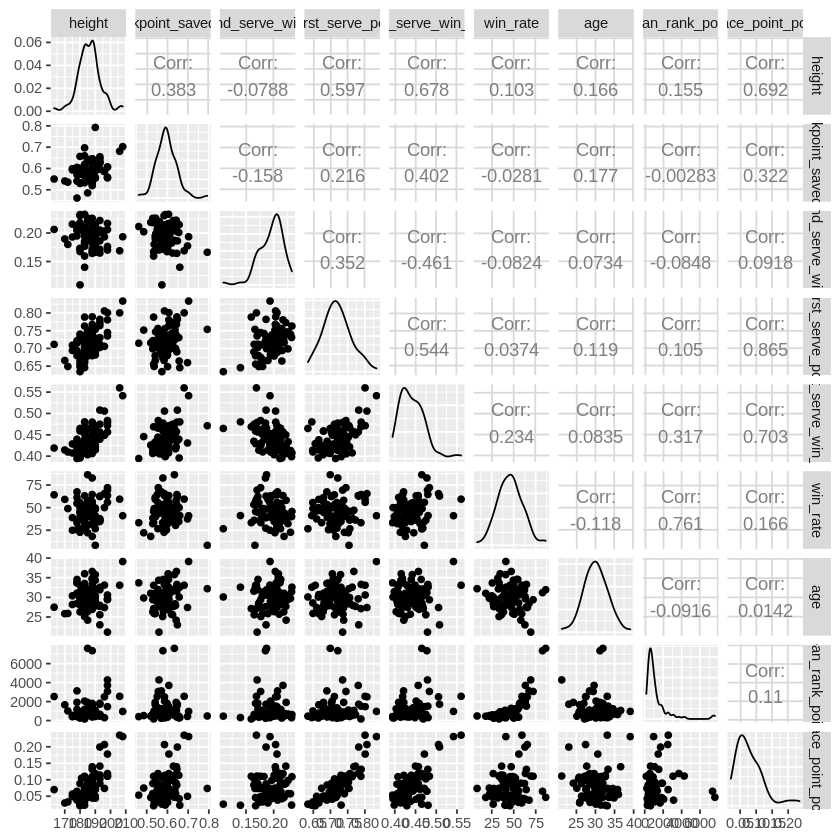

In [122]:
player_ggpairs <- player_train %>%
    select(-player_id) %>%
    ggpairs()

glimpse(player_train)

colnames(player_train)

player_ggpairs

KNN Regression: One predictor - One target (win_rate)

In [123]:
set.seed(1)

predictors <- c(
    'height','breakpoint_saved_pct','second_serve_win_pct','first_serve_pct','first_serve_win_pct','age','mean_rank_points','ace_point_pct'
)

results <- tibble()
results <- mutate(results, predictor = "", best_k = 0, rmspe = 0)

for (pred in predictors) {

    print(pred)
    
    train_data <- player_train %>%
        select(win_rate, all_of(pred))
    
    test_data <- player_test %>%
        select(win_rate, all_of(pred))
    
    tennis_recipe <- recipe(win_rate ~ ., data = train_data) %>%
       step_scale(all_predictors()) %>%
       step_center(all_predictors())
    
    tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("regression")
    
    tennis_vfold <- vfold_cv(train_data, v = 5, strata = win_rate)
    
    tennis_workflow <- workflow() %>%
       add_recipe(tennis_recipe) %>%
       add_model(tennis_spec)
    
    gridvals <- tibble(neighbors = seq(1,40))
    
    tennis_results <- tennis_workflow %>%
       tune_grid(resamples = tennis_vfold, grid = gridvals) %>%
       collect_metrics() %>%
       filter(.metric == "rmse") %>%
       filter(mean == min(mean))
    
    kmin <- pull(tennis_results, neighbors)
    
    tennis_spec_kmin <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
       set_engine("kknn") %>%
       set_mode("regression")
    
    tennis_fit <- workflow() %>%
       add_recipe(tennis_recipe) %>%
       add_model(tennis_spec_kmin) %>%
       fit(data = train_data)
    
    rmspe_val <- tennis_fit %>%
       predict(test_data) %>%
       bind_cols(test_data) %>%
       metrics(truth = win_rate, estimate = .pred) %>%
       filter(.metric == "rmse") %>%
       select(.estimate) %>%
       pull()
    
    
    results <- results %>%
        add_row(predictor = pred, best_k=kmin, rmspe = rmspe_val)
    
}

[1] "height"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "breakpoint_saved_pct"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "second_serve_win_pct"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "first_serve_pct"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "first_serve_win_pct"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "age"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "mean_rank_points"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "ace_point_pct"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


In [124]:
results %>% arrange(rmspe) %>% head()

predictor,best_k,rmspe
<chr>,<dbl>,<dbl>
mean_rank_points,7,10.24509
first_serve_win_pct,36,15.55832
height,37,15.89049
first_serve_pct,28,16.09443
age,39,16.23855
breakpoint_saved_pct,33,16.26547


| Predictor              | RMSE     |
|------------------------|----------|
| mean_rank_points       | 10.23683 |
| height                 | 15.85000 |
| breakpoint_saved_pct   | 16.22718 |
| second_serve_win_pct   | 16.31776 |
| first_serve_pct        | 15.97336 |
| first_serve_win_pct    | 16.26900 |
| age                    | 16.20005 |
| ace_point_pct          | 16.37700 |

KNN Regression: Multiple predictors (mean_rank_points + first_serve_win_pct) - One target (win_rate)

In [125]:
set.seed(1)

tennis_recipe_multiple <- recipe(win_rate ~ mean_rank_points + first_serve_win_pct, data = player_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

tennis_spec_mul <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
   set_engine("kknn") %>%
   set_mode("regression")

tennis_vfold_mul <- vfold_cv(player_train, v = 5, strata = win_rate)

tennis_workflow_multiple <- workflow() %>%
   add_recipe(tennis_recipe_multiple) %>%
   add_model(tennis_spec_mul)

gridvals_mul <- tibble(neighbors = seq(1,40))

tennis_results_multiple <- tennis_workflow_multiple %>%
   tune_grid(resamples = tennis_vfold_mul, grid = gridvals_mul) %>%
   collect_metrics() %>%
   filter(.metric == "rmse") %>%
   filter(mean == min(mean))

kmin_multiple <- pull(tennis_results_multiple, neighbors)

tennis_spec_kmin_mul <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
   set_engine("kknn") %>%
   set_mode("regression")

tennis_fit_multiple <- workflow() %>%
   add_recipe(tennis_recipe_multiple) %>%
   add_model(tennis_spec_kmin_mul) %>%
   fit(data = player_train)

rmspe_val_mul <- tennis_fit_multiple %>%
   predict(player_test) %>%
   bind_cols(player_test) %>%
   metrics(truth = win_rate, estimate = .pred) %>%
   filter(.metric == "rmse") %>%
   select(.estimate)

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


mean_rank_points + first_serve_win_pct

In [126]:
rmspe_val_mul

.estimate
<dbl>
8.328683


KNN Regression: Multiple predictors (mean_rank_points + height) - One target (win_rate)

In [127]:
set.seed(1)

tennis_recipe_multiple <- recipe(win_rate ~ mean_rank_points + height, data = player_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

tennis_spec_mul <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
   set_engine("kknn") %>%
   set_mode("regression")

tennis_vfold_mul <- vfold_cv(player_train, v = 5, strata = win_rate)

tennis_workflow_multiple <- workflow() %>%
   add_recipe(tennis_recipe_multiple) %>%
   add_model(tennis_spec_mul)

gridvals_mul <- tibble(neighbors = seq(1,40))

tennis_results_multiple <- tennis_workflow_multiple %>%
   tune_grid(resamples = tennis_vfold_mul, grid = gridvals_mul) %>%
   collect_metrics() %>%
   filter(.metric == "rmse") %>%
   filter(mean == min(mean))

kmin_multiple <- pull(tennis_results_multiple, neighbors)

tennis_spec_kmin_mul <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
   set_engine("kknn") %>%
   set_mode("regression")

tennis_fit_multiple <- workflow() %>%
   add_recipe(tennis_recipe_multiple) %>%
   add_model(tennis_spec_kmin_mul) %>%
   fit(data = player_train)

rmspe_val_mul <- tennis_fit_multiple %>%
   predict(player_test) %>%
   bind_cols(player_test) %>%
   metrics(truth = win_rate, estimate = .pred) %>%
   filter(.metric == "rmse") %>%
   select(.estimate)

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


mean_rank_points + height

In [128]:
rmspe_val_mul

.estimate
<dbl>
9.877601


KNN Regression: Multiple predictors (mean_rank_points + first_serve_pct) - One target (win_rate)

In [129]:
set.seed(1)

tennis_recipe_multiple <- recipe(win_rate ~ mean_rank_points + first_serve_pct, data = player_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

tennis_spec_mul <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
   set_engine("kknn") %>%
   set_mode("regression")

tennis_vfold_mul <- vfold_cv(player_train, v = 5, strata = win_rate)

tennis_workflow_multiple <- workflow() %>%
   add_recipe(tennis_recipe_multiple) %>%
   add_model(tennis_spec_mul)

gridvals_mul <- tibble(neighbors = seq(1,40))

tennis_results_multiple <- tennis_workflow_multiple %>%
   tune_grid(resamples = tennis_vfold_mul, grid = gridvals_mul) %>%
   collect_metrics() %>%
   filter(.metric == "rmse") %>%
   filter(mean == min(mean))

kmin_multiple <- pull(tennis_results_multiple, neighbors)

tennis_spec_kmin_mul <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
   set_engine("kknn") %>%
   set_mode("regression")

tennis_fit_multiple <- workflow() %>%
   add_recipe(tennis_recipe_multiple) %>%
   add_model(tennis_spec_kmin_mul) %>%
   fit(data = player_train)

rmspe_val_mul <- tennis_fit_multiple %>%
   predict(player_test) %>%
   bind_cols(player_test) %>%
   metrics(truth = win_rate, estimate = .pred) %>%
   filter(.metric == "rmse") %>%
   select(.estimate)

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


mean_rank_points + first_serve_pct

In [130]:
rmspe_val_mul

.estimate
<dbl>
8.858416


KNN Regression: Multiple predictors (mean_rank_points + first_serve_pct + first_serve_win_pct) - One target (win_rate)

In [131]:
set.seed(1)

tennis_recipe_multiple <- recipe(win_rate ~ mean_rank_points + first_serve_pct + first_serve_win_pct, data = player_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

tennis_spec_mul <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
   set_engine("kknn") %>%
   set_mode("regression")

tennis_vfold_mul <- vfold_cv(player_train, v = 5, strata = win_rate)

tennis_workflow_multiple <- workflow() %>%
   add_recipe(tennis_recipe_multiple) %>%
   add_model(tennis_spec_mul)

gridvals_mul <- tibble(neighbors = seq(1,40))

tennis_results_multiple <- tennis_workflow_multiple %>%
   tune_grid(resamples = tennis_vfold_mul, grid = gridvals_mul) %>%
   collect_metrics() %>%
   filter(.metric == "rmse") %>%
   filter(mean == min(mean))

kmin_multiple <- pull(tennis_results_multiple, neighbors)

tennis_spec_kmin_mul <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
   set_engine("kknn") %>%
   set_mode("regression")

tennis_fit_multiple <- workflow() %>%
   add_recipe(tennis_recipe_multiple) %>%
   add_model(tennis_spec_kmin_mul) %>%
   fit(data = player_train)

rmspe_val_mul <- tennis_fit_multiple %>%
   predict(player_test) %>%
   bind_cols(player_test) %>%
   metrics(truth = win_rate, estimate = .pred) %>%
   filter(.metric == "rmse") %>%
   select(.estimate)

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


mean_rank_points + first_serve_pct + first_serve_win_pct

In [132]:
rmspe_val_mul

.estimate
<dbl>
9.462749


KNN Regression: Multiple predictors (mean_rank_points + first_serve_pct + height) - One target (win_rate)

In [133]:
set.seed(1)

tennis_recipe_multiple <- recipe(win_rate ~ mean_rank_points + first_serve_pct + height, data = player_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

tennis_spec_mul <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
   set_engine("kknn") %>%
   set_mode("regression")

tennis_vfold_mul <- vfold_cv(player_train, v = 5, strata = win_rate)

tennis_workflow_multiple <- workflow() %>%
   add_recipe(tennis_recipe_multiple) %>%
   add_model(tennis_spec_mul)

gridvals_mul <- tibble(neighbors = seq(1,40))

tennis_results_multiple <- tennis_workflow_multiple %>%
   tune_grid(resamples = tennis_vfold_mul, grid = gridvals_mul) %>%
   collect_metrics() %>%
   filter(.metric == "rmse") %>%
   filter(mean == min(mean))

kmin_multiple <- pull(tennis_results_multiple, neighbors)

tennis_spec_kmin_mul <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
   set_engine("kknn") %>%
   set_mode("regression")

tennis_fit_multiple <- workflow() %>%
   add_recipe(tennis_recipe_multiple) %>%
   add_model(tennis_spec_kmin_mul) %>%
   fit(data = player_train)

rmspe_val_mul <- tennis_fit_multiple %>%
   predict(player_test) %>%
   bind_cols(player_test) %>%
   metrics(truth = win_rate, estimate = .pred) %>%
   filter(.metric == "rmse") %>%
   select(.estimate)

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


mean_rank_points + first_serve_pct + height

In [134]:
rmspe_val_mul

.estimate
<dbl>
10.38991


| KNN REGRESSION -- Predictors                                   | RMSPE    |
|----------------------------------------------------------------|----------|
| mean_rank_points + first_serve_win_pct                         | 12.34905 |
| mean_rank_points + height                                      | 12.14781 |
| mean_rank_points + first_serve_pct                             | 12.09393 |
| mean_rank_points + first_serve_pct + first_serve_win_pct       | 13.09474 |
| mean_rank_points + first_serve_pct + height                    | 12.64508 |

In [137]:
set.seed(1)

lm_predictors <- c(
    'height','breakpoint_saved_pct','second_serve_win_pct','first_serve_pct','first_serve_win_pct','age','mean_rank_points','ace_point_pct'
)

lm_results <- tibble()
lm_results <- mutate(lm_results, lm_predictor = "", lm_rmspe = 0)

for (lm_pred in lm_predictors) {

    print(lm_pred)
    
    lm_train_data <- player_train %>%
        select(win_rate, all_of(lm_pred))
    
    lm_test_data <- player_test %>%
        select(win_rate, all_of(lm_pred))
    
    tennis_lm_recipe <- recipe(win_rate ~ ., data = lm_train_data) %>%
       step_scale(all_predictors()) %>%
       step_center(all_predictors())
    
    tennis_lm_spec <- linear_reg() %>%
        set_engine("lm") %>%
        set_mode("regression")

    tennis_lm_fit <- workflow() %>%
       add_recipe(tennis_lm_recipe) %>%
       add_model(tennis_lm_spec) %>%
       fit(data = lm_train_data)
    
    lm_rmspe_val <- tennis_lm_fit %>%
         predict(lm_test_data) %>%
         bind_cols(lm_test_data) %>%
         metrics(truth = win_rate, estimate = .pred) %>%
         filter(.metric == "rmse") %>%
         select(.estimate) %>%
         pull()
    
    lm_results <- lm_results %>%
        add_row(lm_predictor = lm_pred, lm_rmspe = lm_rmspe_val)
    
}

lm_results %>%
    arrange(lm_rmspe)

lm_results %>%
    arrange(lm_rmspe) %>%
    pull(lm_predictor)


[1] "height"
[1] "breakpoint_saved_pct"
[1] "second_serve_win_pct"
[1] "first_serve_pct"
[1] "first_serve_win_pct"
[1] "age"
[1] "mean_rank_points"
[1] "ace_point_pct"


lm_predictor,lm_rmspe
<chr>,<dbl>
mean_rank_points,9.741566
first_serve_win_pct,15.125446
ace_point_pct,15.853011
⋮,⋮
breakpoint_saved_pct,16.03625
second_serve_win_pct,16.18525
age,16.22005


[1] "mean_rank_points"     "first_serve_win_pct"  "ace_point_pct"       
[4] "first_serve_pct"      "height"               "breakpoint_saved_pct"
[7] "second_serve_win_pct" "age"

Linear Regression -- One predictor - One target (win_rate) -- mjbrodie edits

In [138]:
set.seed(1)

lm_predictors <- c(
    'height','breakpoint_saved_pct','second_serve_win_pct','first_serve_pct','first_serve_win_pct','age','mean_rank_points','ace_point_pct'
)

lm_results <- tibble()
lm_results <- mutate(lm_results, lm_predictor = "", lm_rmspe = 0)

for (lm_pred in lm_predictors) {

    print(lm_pred)
    
    lm_train_data <- player_train %>%
        select(win_rate, all_of(lm_pred))
    
    lm_test_data <- player_test %>%
        select(win_rate, all_of(lm_pred))
    
    tennis_lm_recipe <- recipe(win_rate ~ ., data = lm_train_data)
    
    tennis_lm_spec <- linear_reg() %>%
        set_engine("lm") %>%
        set_mode("regression")

    tennis_lm_fit <- workflow() %>%
       add_recipe(tennis_lm_recipe) %>%
       add_model(tennis_lm_spec) %>%
       fit(data = lm_train_data)
    
    lm_rmspe_val <- tennis_lm_fit %>%
         predict(lm_test_data) %>%
         bind_cols(lm_test_data) %>%
         metrics(truth = win_rate, estimate = .pred) %>%
         filter(.metric == "rmse") %>%
         select(.estimate) %>%
         pull()
    
    lm_results <- lm_results %>%
        add_row(lm_predictor = lm_pred, lm_rmspe = lm_rmspe_val)
    
}

lm_results %>%
    arrange(lm_rmspe)

[1] "height"
[1] "breakpoint_saved_pct"
[1] "second_serve_win_pct"
[1] "first_serve_pct"
[1] "first_serve_win_pct"
[1] "age"
[1] "mean_rank_points"
[1] "ace_point_pct"


lm_predictor,lm_rmspe
<chr>,<dbl>
mean_rank_points,9.741566
first_serve_win_pct,15.125446
ace_point_pct,15.853011
⋮,⋮
breakpoint_saved_pct,16.03625
second_serve_win_pct,16.18525
age,16.22005


Linear Regression: Multiple predictors (mean_rank_points + first_serve_win_pct) - One target (win_rate)

In [139]:
set.seed(1)

tennis_spec_lm <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

tennis_recipe_lm <- recipe(win_rate ~ mean_rank_points + first_serve_win_pct, data = player_train)

tennis_fit_lm <- workflow() %>%
    add_recipe(tennis_recipe_lm) %>%
    add_model(tennis_spec_lm) %>%
    fit(data = player_train)

tennis_results_lm <- tennis_fit_lm %>%
    predict(player_test) %>%
    bind_cols(player_test) %>%
    metrics(truth = win_rate, estimate = .pred) %>%
    filter(.metric == "rmse")

tennis_results_lm

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,9.761017


Linear Regression: Multiple predictors (mean_rank_points + height) - One target (win_rate)

In [140]:
set.seed(1)

tennis_spec_lm <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

tennis_recipe_lm <- recipe(win_rate ~ mean_rank_points + height, data = player_train)

tennis_fit_lm <- workflow() %>%
    add_recipe(tennis_recipe_lm) %>%
    add_model(tennis_spec_lm) %>%
    fit(data = player_train)

tennis_results_lm <- tennis_fit_lm %>%
    predict(player_test) %>%
    bind_cols(player_test) %>%
    metrics(truth = win_rate, estimate = .pred) %>%
    filter(.metric == "rmse")

tennis_results_lm

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,9.72332


Linear Regression: Multiple predictors (mean_rank_points + first_serve_pct) - One target (win_rate)

In [141]:
set.seed(1)

tennis_spec_lm <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

tennis_recipe_lm <- recipe(win_rate ~ mean_rank_points + first_serve_pct, data = player_train)

tennis_fit_lm <- workflow() %>%
    add_recipe(tennis_recipe_lm) %>%
    add_model(tennis_spec_lm) %>%
    fit(data = player_train)

tennis_results_lm <- tennis_fit_lm %>%
    predict(player_test) %>%
    bind_cols(player_test) %>%
    metrics(truth = win_rate, estimate = .pred) %>%
    filter(.metric == "rmse")

tennis_results_lm

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,9.699788


Linear Regression: Multiple predictors (mean_rank_points + first_serve_win_pct + first_serve_pct) - One target (win_rate)

In [142]:
set.seed(1)

tennis_spec_lm <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

tennis_recipe_lm <- recipe(win_rate ~ mean_rank_points + first_serve_win_pct + first_serve_pct, data = player_train)

tennis_fit_lm <- workflow() %>%
    add_recipe(tennis_recipe_lm) %>%
    add_model(tennis_spec_lm) %>%
    fit(data = player_train)

tennis_results_lm <- tennis_fit_lm %>%
    predict(player_test) %>%
    bind_cols(player_test) %>%
    metrics(truth = win_rate, estimate = .pred) %>%
    filter(.metric == "rmse")

tennis_results_lm

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,9.64302


Linear Regression: Multiple predictors (mean_rank_points + first_serve_pct + height) - One target (win_rate)

In [143]:
set.seed(1)

tennis_spec_lm <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

tennis_recipe_lm <- recipe(win_rate ~ mean_rank_points + first_serve_pct + height, data = player_train)

tennis_fit_lm <- workflow() %>%
    add_recipe(tennis_recipe_lm) %>%
    add_model(tennis_spec_lm) %>%
    fit(data = player_train)

tennis_results_lm <- tennis_fit_lm %>%
    predict(player_test) %>%
    bind_cols(player_test) %>%
    metrics(truth = win_rate, estimate = .pred) %>%
    filter(.metric == "rmse")

tennis_results_lm

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,9.71052


In [144]:
set.seed(1)

tennis_spec_lm <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

tennis_recipe_lm <- recipe(win_rate ~ mean_rank_points + first_serve_pct + height, data = player_train)

tennis_fit_lm <- workflow() %>%
    add_recipe(tennis_recipe_lm) %>%
    add_model(tennis_spec_lm) %>%
    fit(data = player_train)

tennis_results_lm <- tennis_fit_lm %>%
    predict(player_test) %>%
    bind_cols(player_test) %>%
    metrics(truth = win_rate, estimate = .pred) %>%
    filter(.metric == "rmse")

tennis_results_lm

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,9.71052


In [145]:
tennis_results_lm

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,9.71052


| LINEAR REGRESSION -- Predictors                                | RMSPE    |
|----------------------------------------------------------------|----------|
| mean_rank_points + first_serve_win_pct                         | 9.718589 |
| mean_rank_points + height                                      | 9.682601 |
| mean_rank_points + first_serve_pct                             | 9.658411 |
| mean_rank_points + first_serve_pct + first_serve_win_pct       | 9.603781 |
| mean_rank_points + first_serve_pct + height                    | 9.668343 |